#### [数据集说明 dataset description]

##### 数据来源 Data Sources

[数据来源](http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)

##### 数据结构 data structure

见struct.jpg

#### 一、环境配置 Environment configuration

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# 修改imputer为SimpleImputer
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize
from sklearn import metrics

import seaborn as sns
# from sklearn.metrics import roc_curve, auc, roc_auc_score

#### 二、数据信息配置 Data information configuration

In [13]:
# 定义根路径
# root =  '/Users/authorcai/Documents/Authorcai/CSH/HumanActivityRecognize-master/Data/UCI_HAR_Dataset/'
root = 'C:/Users/Authorcai/CSH/HumanActivityRecognization/UCI_HAR_Dataset/UCI_HAR_Dataset/'

In [14]:
# 读取数据
features = pd.read_csv(root + 'features.txt', sep='\s+', index_col=0, header=None)
train_data = pd.read_csv(root + 'train/X_train.txt', sep='\s+')
test_data = pd.read_csv(root + 'test/X_test.txt', sep='\s+')

train_data.columns = list(features.values.ravel())
test_data.columns = list(features.values.ravel())

train_label = pd.read_csv(root + 'train/y_train.txt', sep='\s+', header=None)
test_label = pd.read_csv(root + 'test/y_test.txt', sep='\s+', header=None)
label_name = pd.read_csv(root + 'activity_labels.txt', sep='\s+', header=None)

# drop掉label_name自带的索引列
label_name = label_name.drop(columns=0,axis=1)

In [15]:
# 标签信息查看
label_name

,1
0,WALKING
1,WALKING_UPSTAIRS
2,WALKING_DOWNSTAIRS
3,SITTING
4,STANDING
5,LAYING


In [16]:
# 处理label数据
def get_label_name(num):
    return label_name.iloc[num-1,0]#在原来的标签号基础上减一


In [17]:
train_data['label']=train_label
test_data['label']=test_label

In [18]:
# 匹配索引号和对应姿势名称
train_data['label_name']=train_data['label'].map(get_label_name)
test_data['label_name']=test_data['label'].map(get_label_name)

# 查看train_data是否匹配成功
pd.DataFrame(train_data['label_name'])['label_name'].value_counts()
# 查看test_data是否匹配成功
pd.DataFrame(test_data['label_name'])['label_name'].value_counts()

LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      470
WALKING_DOWNSTAIRS    420
Name: label_name, dtype: int64

<AxesSubplot:title={'center':'activity type'}>

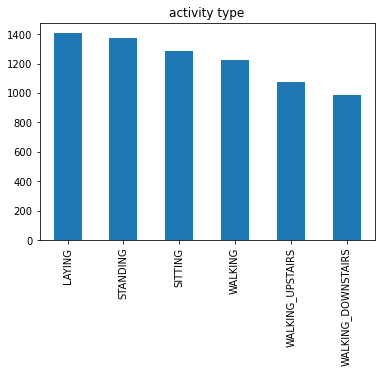

In [19]:
# 训练数据分类数量
train_data['label_name'].value_counts().plot(kind='bar', title='activity type')

<AxesSubplot:title={'center':'activity type'}>

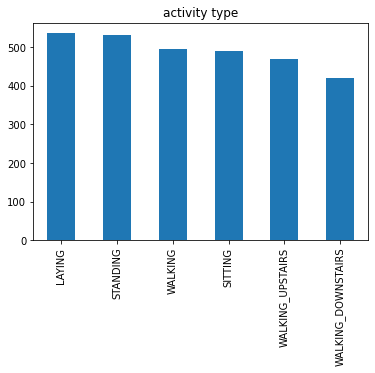

In [20]:
# 训练数据分类数量
test_data['label_name'].value_counts().plot(kind='bar', title='activity type')

##### （一）处理空值 Handling null values

In [21]:
# 将初始数据的空值用NaN替代
train_data.replace("?",np.NaN).head()
test_data.replace("?",np.NaN).head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",label,label_name
0,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,5,STANDING
1,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,5,STANDING
2,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,5,STANDING
3,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,5,STANDING
4,0.279220,-0.018620,-0.113902,-0.994455,-0.970417,-0.965316,-0.994585,-0.969481,-0.965897,-0.937856,...,-0.857565,-0.095681,0.048849,0.760684,-0.072216,-0.689816,0.294896,-0.068471,5,STANDING


##### （二）处理缺省值 Handling default values

In [22]:
# 无缺省，无需处理缺省值

##### （三）训练集和测试集信息说明 Training set and test set information description

In [23]:
print("训练集样本模型:%d，特征属性：%d, 目标属性:%d " %(train_data.shape[0],train_data.shape[1],train_label.shape[1]))

训练集样本模型:7351，特征属性：563, 目标属性:1 


##### （四）根据算法要求处理数据  Process data according to algorithm requirements

In [24]:
#制作训练集和测试集，使格式符合sklean算法要求
x_train=train_data.iloc[:,:-2].values # 训练集X特征数据
x_test=train_data.iloc[:,-2].values # 训练集X标签数据
y_train=test_data.iloc[:,:-2].values # 测试集Y合特征数据
y_test=test_data.iloc[:,-2].values # 测试集Y标签数据


In [25]:
pd.DataFrame(y_test)[0].value_counts()

6    537
5    532
1    496
4    491
2    470
3    420
Name: 0, dtype: int64

In [26]:
# 查看处理后的数据信息
print(x_train.shape)
print(x_test.shape)

(7351, 561)
(7351,)


#### 三、对数据进行降维分析 Perform dimensionality reduction analysis on data

##### （一）TSNE降维分析 Dimensionality reduction analysis

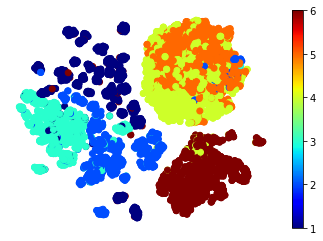

In [27]:
# 数据降维分析TSNE
#对数据进行降维可视化
#使用t-sne进行可视化分析
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2)#调入t-sne(将数据降成二维)
out=tsne.fit_transform(x_train)#使用t-sne，处理数据
plt.scatter(out[:, 0], out[:, 1], c=x_test,cmap='jet')#画图
plt.axis('off')
plt.colorbar()
plt.show()

##### （二）PCA降维分析 Dimensionality reduction analysis

In [28]:
# PCA降维
from sklearn.decomposition import PCA
pca = PCA(.99)#建立pca模型
X2D = pca.fit_transform(x_train)#使用pca，处理数据，训练并降维
radtio=pca.explained_variance_ratio_#画图，每个主成成分占方差比例
print(pca.n_components)#n_components指示主成成分有有的元素数量

0.99


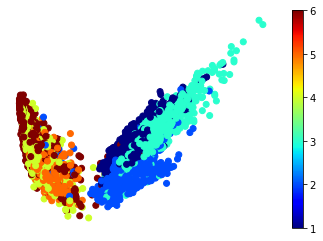

In [29]:
# PCA降维结果可视化
plt.scatter(X2D[:, 0], X2D[:, 1], c=x_test,cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

##### （三）降维结果总结 Summary of dimensionality reduction results

In [30]:
#pca降维，失去了结构信息;
#t-sne使属于流形学习，能将高维流形映射到低维空间，保留了结构;
#通过t-snef降维分析结果可知，使用该方法效果更加直观;
#从分析结果大致可以看出姿势3和姿势4,姿势5不好区分

#### 四、根据特征对数据进行分布分析 Distribute analysis of data based on characteristics

##### （一）定义特征分布分析函数 Define the feature distribution analysis function

In [31]:
#对某一个特征观察分布，输入为特征列名称，输出为分布结果
def plot_feature(feature_name):#想分析哪个特征，就将特征名输入函数即可
    plt.figure(figsize=(10,5))
    plt.title("Sensor data distribution for all label")
    class_indexs=list(label_name.values.ravel())#得到所有类别
    for class_index in class_indexs:#根据类别，画出
        sns.distplot(train_data[train_data['label_name']==class_index][feature_name], label=class_index)
    plt.legend()#给图像加上图例
    plt.show()# plots the distribution of all the columns of both left and wright wrist

In [34]:
# for column in list(train_data.columns):
#     print(column)

In [33]:
# 定义函数用于展示不同特征（63项）在6类姿态下的数值分布情况
# 定义列表存储特征名
features = list(train_data.columns)
# 定义函数存储每个特征对应的数值数量分布图
def plot_all_features()

SyntaxError: invalid syntax (<ipython-input-33-5866ac8152f1>, line 5)

##### （二）依次分析特征 Analyze features in turn

###### （1）特征 feature一：tBodyAcc-mean()-X

C:\Users\Authorcai\.conda\envs\Cloth\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Authorcai\.conda\envs\Cloth\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Authorcai\.conda\envs\Cloth\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

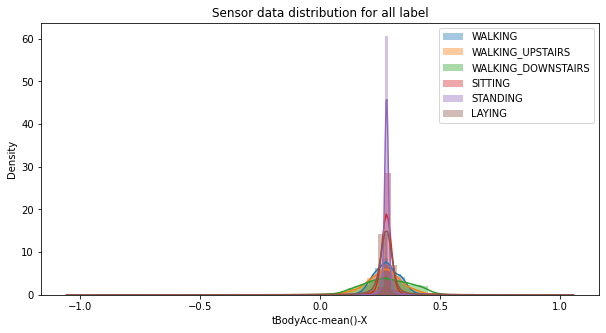

In [35]:
plot_feature('tBodyAcc-mean()-X')

###### （2）特征二：tBodyAcc-energy()-X

C:\Users\Authorcai\.conda\envs\Cloth\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Authorcai\.conda\envs\Cloth\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Authorcai\.conda\envs\Cloth\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

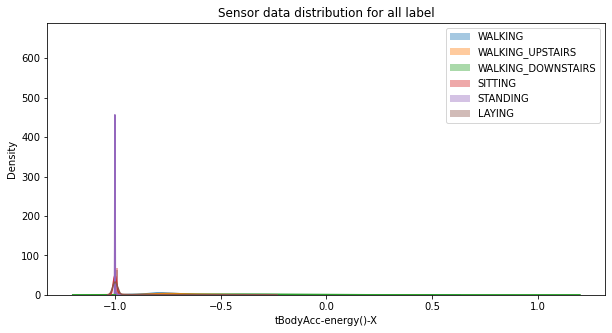

In [36]:
plot_feature('tBodyAcc-energy()-X')

###### （3）特征三：angle(X,gravityMean)

C:\Users\Authorcai\.conda\envs\Cloth\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Authorcai\.conda\envs\Cloth\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Authorcai\.conda\envs\Cloth\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

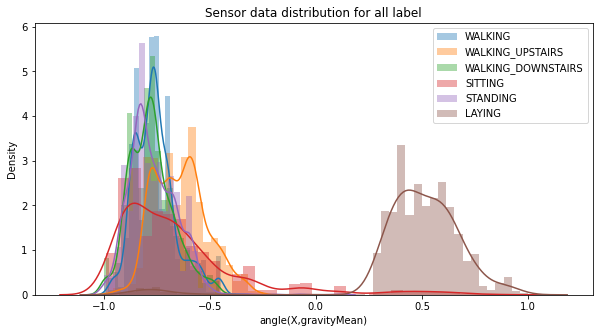

In [37]:
plot_feature('angle(X,gravityMean)')

#### 三、建立随机森林模型训练 Build random forest model training

##### （一）构建模型 Build model

In [38]:
from sklearn.ensemble import RandomForestClassifier
# 使用GridSeachCV自动调参，解决手动调参存在的种种问题
from sklearn.model_selection import GridSearchCV 
#对max_features和n_estimators进行选择
clf = RandomForestClassifier(max_features=None,random_state=0)
estimator=np.arange(20,160,40)
my_max_features = [ "sqrt", "log2"]
param_grid={'n_estimators':estimator,"max_features":my_max_features}
gs=GridSearchCV(estimator=clf,param_grid=param_grid,cv=10,verbose=4,n_jobs=-1)

##### （二）训练模型 Training model

In [39]:
gs.fit(x_train,x_test)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_features=None,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': array([ 20,  60, 100, 140])},
             verbose=4)

##### （三）评估模型 Evaluation model

In [40]:
# 通过best_score
best_score = gs.best_score_
best_param = gs.best_params_
best_estimator = gs.best_estimator_
print("(1)模型的准确率为：%.2f%%\n" %(best_score*100))

# 通过表格形式展示参数数据
print("(2)模型的最佳参数信息：")
dict = pd.DataFrame(pd.Series(best_param),columns=['value'])
dict

(1)模型的准确率为：90.93%

(2)模型的最佳参数信息：


,value
max_features,log2
n_estimators,100


##### （四）模型预测 Model prediction

###### （1）获取预测结果 Get prediction results

In [41]:
# 通过predict获取模型预测结果
prediction = best_estimator.predict(y_train)
prediction_new = pd.DataFrame(prediction)
prediction_new.columns=['activity']

# 对预测结果数量进行统计
prediction_new['activity'].value_counts()
prediction_new

# 对预测结果标签进行数字替换，按names进行替换
names = {
    1:'WALKING',
    2:'WALKING_UPSTAIRS',
    3:'WALKING_DOWNSTAIRS',
    4:'SITTING',
    5:'STANDING',
    6:'LAYING'
}
prediction_new['activity']= prediction_new['activity'].map(names)
# prediction_new.loc[prediction_new['activity' == 1]] = names[1]
# prediction_new.loc[prediction_new['activity' == 2]] = names[2]
# prediction_new.loc[prediction_new['activity' == 3]] = names[3]
# prediction_new.loc[prediction_new['activity' == 4]] = names[4]
# prediction_new.loc[prediction_new['activity' == 5]] = names[5]
# prediction_new.loc[prediction_new['activity' == 6]] = names[6]

# 查看预测结果信息
prediction_new['activity'].describe()
prediction_new['activity'].value_counts()

STANDING              559
LAYING                535
WALKING               534
WALKING_UPSTAIRS      502
SITTING               456
WALKING_DOWNSTAIRS    360
Name: activity, dtype: int64

###### (2)处理预测结果 Processing forecast results

In [42]:
y_true = y_test

In [43]:
pd.DataFrame(prediction)[0].value_counts()

5    559
6    535
1    534
2    502
4    456
3    360
Name: 0, dtype: int64

In [44]:
pd.DataFrame(y_true)[0].value_counts()

6    537
5    532
1    496
4    491
2    470
3    420
Name: 0, dtype: int64

In [45]:
# 对prediciton 作-1处理
i = 0
for value in prediction:
    prediction[i]=value-1
    i = i+1
    
# 对y_test 作-1处理
i = 0
for value in y_test:
    y_true[i]=value-1
    i = i+1


In [46]:
pd.DataFrame(prediction)[0].value_counts()

4    559
5    535
0    534
1    502
3    456
2    360
Name: 0, dtype: int64

In [47]:
pd.DataFrame(y_true)[0].value_counts()

5    537
4    532
0    496
3    491
1    470
2    420
Name: 0, dtype: int64

In [48]:
prediction

array([4, 4, 4, ..., 1, 1, 0], dtype=int64)

###### （2）预测结果可视化 Visualization of forecast results

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# 生成获取混淆矩阵
cm = confusion_matrix(y_true=y_true,y_pred=prediction)

In [50]:
# 查看混淆矩阵
cm

array([[466,   9,  21,   0,   0,   0],
       [ 20, 430,  10,   0,  10,   0],
       [ 32,  59, 327,   0,   2,   0],
       [  0,   1,   0, 428,  46,  16],
       [  0,   3,   0,  28, 501,   0],
       [ 16,   0,   2,   0,   0, 519]], dtype=int64)

In [51]:
# 混淆矩阵信息添加
columns = ['WALKING', 'WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
cm_df = pd.DataFrame(cm)
cm_df.columns = columns
cm_df.index = columns

# 展示混淆矩阵
cm_df

,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,466,9,21,0,0,0
WALKING_UPSTAIRS,20,430,10,0,10,0
WALKING_DOWNSTAIRS,32,59,327,0,2,0
SITTING,0,1,0,428,46,16
STANDING,0,3,0,28,501,0
LAYING,16,0,2,0,0,519


Text(32.09374999999999, 0.5, 'true')

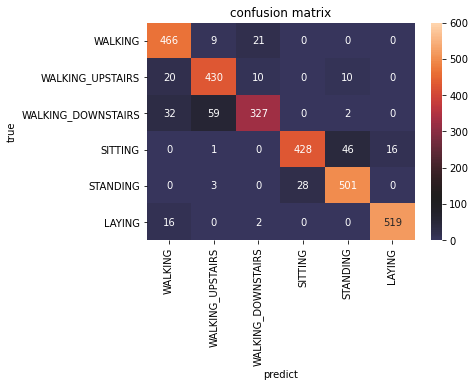

In [52]:
import seaborn as sns
#转换成dataframe，转不转一样
#fmt参数不使用科学计数法进行显示
ax = sns.heatmap(cm_df,annot=True,fmt='.20g',center=120,vmin=0,vmax=600)
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴

#### 四、结果分析 Result analysis

##### （一）重要程度分析 Importance analysis

##### （二）模型评价 Model evaluation

* 使用随机森林模型可以有效地分辨静态姿势和动态姿势
* 在使用随机森林模型处理时，对静态姿势的分类存在缺陷（不足）
* 随机森林模型在辨别sitting 和 standing分类时，存在较大缺陷

#### 四、可结合其他机器学习方法 Can be combined with other machine learning methods

##### （一）使用线性模型处理 Use linear model processing

##### （二）尝试其他类型的分类器：SVM、梯度提升树等 Try other types of classifiers: SVM, gradient boosting tree, etc.